## Deep Neural Network

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 1.1 MB/s  0:01:37m0:00:0100:04
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.9 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 2.5 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 2.1 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [torch]32m6/7 [torch]ck]
Loading data...
Dataset shape: (390153, 24)

Target distribution:
y_active
0    208382
1    181771
Name: count, dtype: int64
Target balance: 46.59% active users

Features used: ['isClick', 'isComment', 'isIntoPersonalHomepage', 'isShare', 'isViewComment', 'isLike', 'province', 'publishTime', 'type', 'creatorType', 'creator_level', 'PushlishMlogCnt', 'day', 'age_gender_missing', 'pop_index_pca_lag1', 'mlogViewTime_log', 'impressPosition_log', 'followCnt_log']
Conv

/opt/anaconda3/envs/music-thesis/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



TRAINING DEEP NEURAL NETWORK
Epoch 1/50 | Train Loss: 0.6430 | Train Acc: 0.6140 | Val Loss: 0.6186 | Val Acc: 0.6380 | Val AUC: 0.6921
Epoch 2/50 | Train Loss: 0.6209 | Train Acc: 0.6363 | Val Loss: 0.6073 | Val Acc: 0.6475 | Val AUC: 0.7064
Epoch 3/50 | Train Loss: 0.6139 | Train Acc: 0.6428 | Val Loss: 0.6021 | Val Acc: 0.6553 | Val AUC: 0.7149
Epoch 4/50 | Train Loss: 0.6099 | Train Acc: 0.6469 | Val Loss: 0.5983 | Val Acc: 0.6544 | Val AUC: 0.7168
Epoch 5/50 | Train Loss: 0.6079 | Train Acc: 0.6474 | Val Loss: 0.5974 | Val Acc: 0.6558 | Val AUC: 0.7177
Epoch 6/50 | Train Loss: 0.6058 | Train Acc: 0.6501 | Val Loss: 0.5957 | Val Acc: 0.6601 | Val AUC: 0.7201
Epoch 7/50 | Train Loss: 0.6047 | Train Acc: 0.6510 | Val Loss: 0.5929 | Val Acc: 0.6617 | Val AUC: 0.7223
Epoch 8/50 | Train Loss: 0.6050 | Train Acc: 0.6505 | Val Loss: 0.5951 | Val Acc: 0.6593 | Val AUC: 0.7211
Epoch 9/50 | Train Loss: 0.6040 | Train Acc: 0.6527 | Val Loss: 0.5941 | Val Acc: 0.6621 | Val AUC: 0.7242
Epoch 1

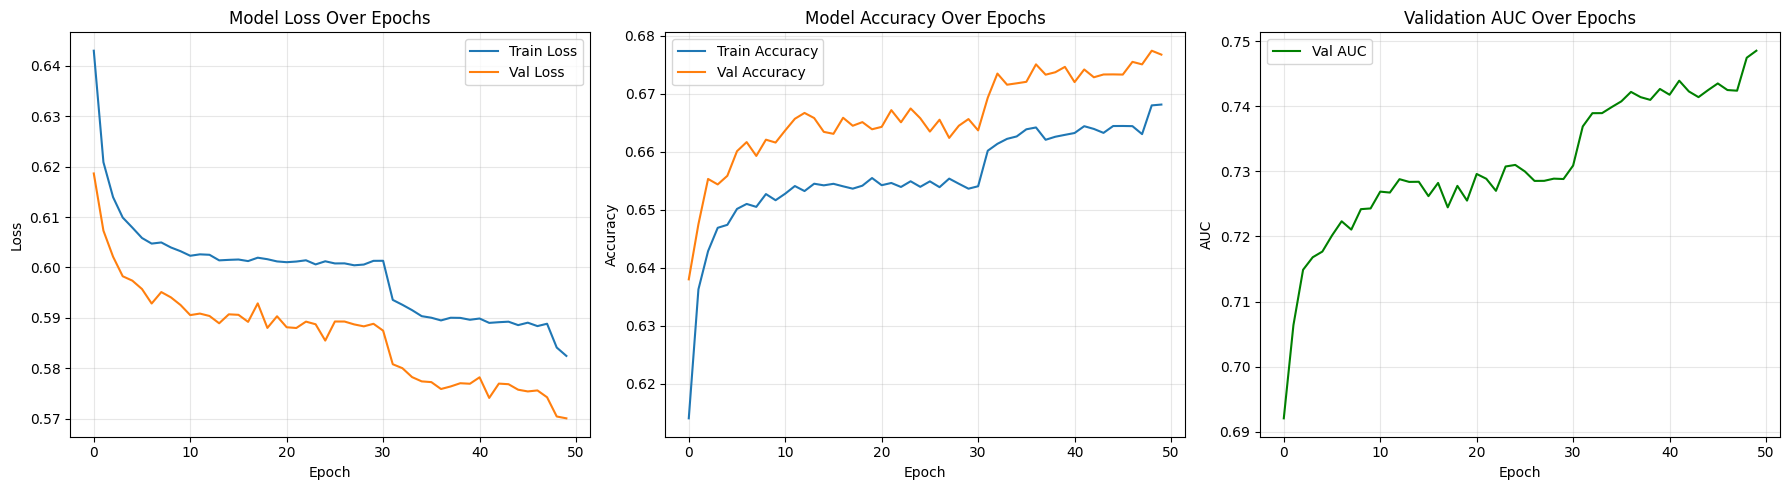


MODEL EVALUATION RESULTS (TEST SET)

Accuracy: 0.6778
ROC-AUC Score: 0.7515

Classification Report:
              precision    recall  f1-score   support

    Inactive       0.65      0.84      0.74     41677
      Active       0.73      0.49      0.59     36354

    accuracy                           0.68     78031
   macro avg       0.69      0.67      0.66     78031
weighted avg       0.69      0.68      0.67     78031


Confusion Matrix:
[[35119  6558]
 [18586 17768]]

Evaluation plots saved as 'dnn_evaluation.png'


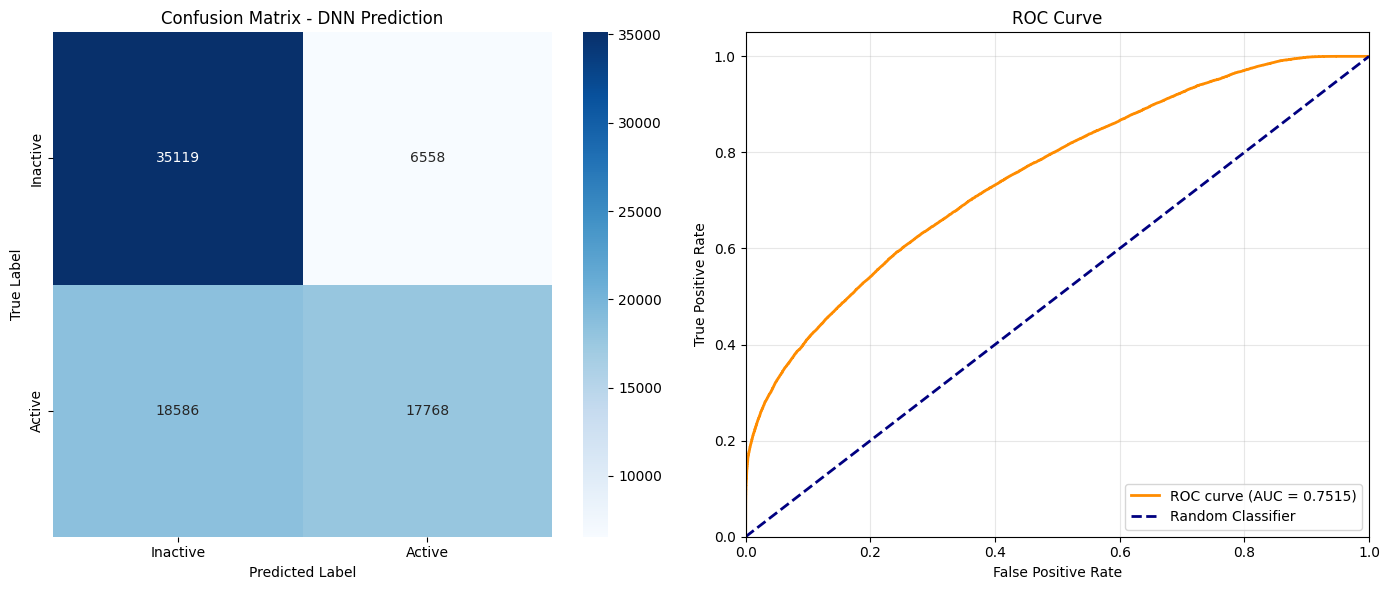

Prediction distribution saved as 'prediction_distribution.png'


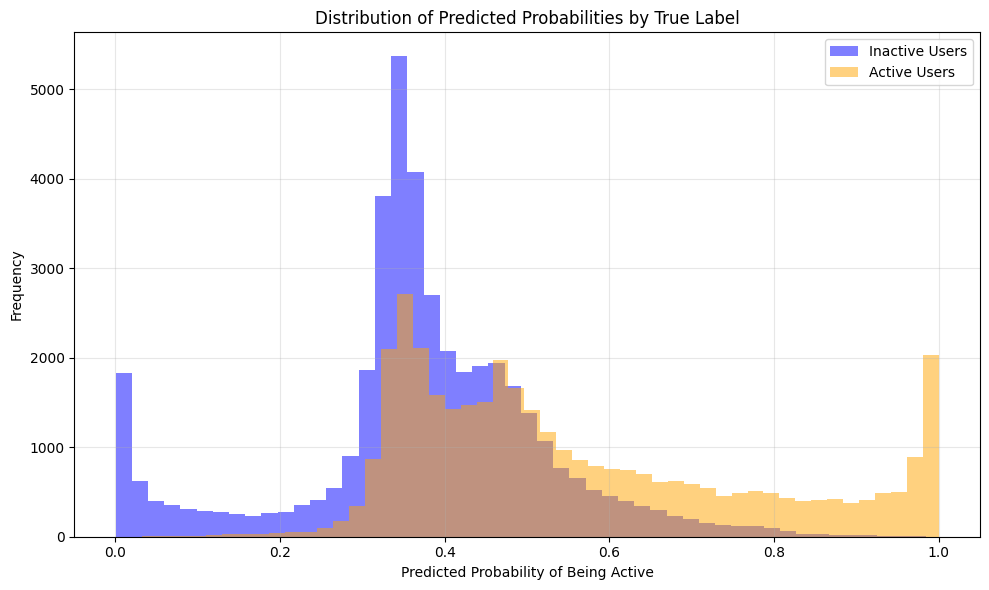


DNN training and evaluation complete!


In [ ]:
!pip install torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the data
print("Loading data...")
df = pd.read_csv("../data/cleaned_data.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:\n{df['y_active'].value_counts()}")
print(f"Target balance: {df['y_active'].mean():.2%} active users")

# Define target
target = 'y_active'
y = df[target].values

# Select features - exclude high cardinality ID columns
exclude_cols = [target, 'userId', 'mlogId', 'creatorId', 'contentId', 'talkId']
X = df.drop(columns=exclude_cols)

print(f"\nFeatures used: {list(X.columns)}")

# Convert day column to numeric temporal features
if 'day' in X.columns:
    X['day'] = pd.to_datetime(X['day'])
    X['day_of_month'] = X['day'].dt.day
    X['day_of_week'] = X['day'].dt.dayofweek
    X['month'] = X['day'].dt.month
    X['days_since_start'] = (X['day'] - X['day'].min()).dt.days  # Temporal progression
    X = X.drop(columns=['day'])
    print("Converted day to temporal numeric features")

# Handle categorical columns
categorical_cols = ['province', 'type', 'creatorType']
categorical_cols = [col for col in categorical_cols if col in X.columns]
print(f"\nCategorical columns to encode: {categorical_cols}")

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False, dtype=np.float32)

print(f"\nFeatures after encoding: {X_encoded.shape[1]}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Further split train into train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Validation set size: {X_val.shape[0]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures standardized")

# Calculate class weights for imbalanced data
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Positive class weight: {pos_weight:.2f}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Define Deep Neural Network
class UserActivityDNN(nn.Module):
    def __init__(self, input_dim):
        super(UserActivityDNN, self).__init__()
        
        self.network = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Layer 2
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Layer 3
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Layer 4
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Output
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

input_dim = X_train_scaled.shape[1]
model = UserActivityDNN(input_dim).to(device)

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss and optimizer with class weights
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    return total_loss / len(loader), correct / total

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    accuracy = accuracy_score(all_labels, (all_preds > 0.5).astype(int))
    auc = roc_auc_score(all_labels, all_preds)
    
    return total_loss / len(loader), accuracy, auc

# Training loop
print("\n" + "="*60)
print("TRAINING DEEP NEURAL NETWORK")
print("="*60)

num_epochs = 50
best_val_loss = float('inf')
patience = 10
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_auc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print("\nBest model loaded")

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_title('Model Loss Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Accuracy')
axes[1].plot(history['val_acc'], label='Val Accuracy')
axes[1].set_title('Model Accuracy Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['val_auc'], label='Val AUC', color='green')
axes[2].set_title('Validation AUC Over Epochs')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test set evaluation
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_pred_proba = model(X_test_tensor).cpu().numpy().flatten()

y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluation metrics
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS (TEST SET)")
print("="*60)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Inactive', 'Active']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Inactive', 'Active'],
            yticklabels=['Inactive', 'Active'])
axes[0].set_title('Confusion Matrix - DNN Prediction')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction distribution
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='Inactive Users', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Active Users', color='orange')
plt.xlabel('Predicted Probability of Being Active')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities by True Label')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DNN training and evaluation complete!")
print("="*60)